# Gaussian Processes in Pyro
The model of interest is:
$$f \sim \mathcal{GP}(0, \mathbf{K}_f(x, x'))$$
where we have that 
$$y = f(x) + \varepsilon \quad \varepsilon \sim \mathcal{N}(0, \beta^{-1}\mathbf{I})$$
We will use the radiabl basis function kernel, which is parametrized in terms of parameters $\sigma^2, l$


In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0)

In [2]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)


def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)


The data we observe consists of 20 points sampled from:
$$y = 0.5 \sin(3x) + \varepsilon \quad \varepsilon \sim \mathcal{N}(0, 0.2)$$
and the sample from x are obtained uniformely in $[0.5]$

In [13]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=[N])
y = 0.5*torch.sin(3*X) + dist.Normal(0, 0.2).sample(sample_shape = [N])

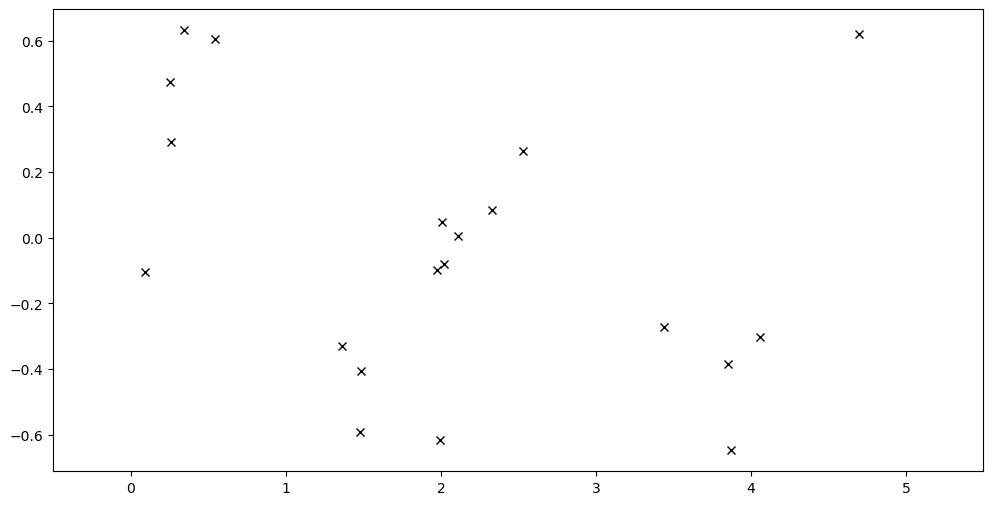

In [14]:
plot(plot_observed_data=True)

In [22]:
# Define the RBF kernel
kernel = gp.kernels.RBF(
    input_dim=1, variance = torch.tensor(6.0), lengthscale = torch.tensor(0.05)
)
gpr = gp.models.GPRegression(X, y, kernel, noise = torch.tensor(0.1)) # this noise corresponds to the epsilon above

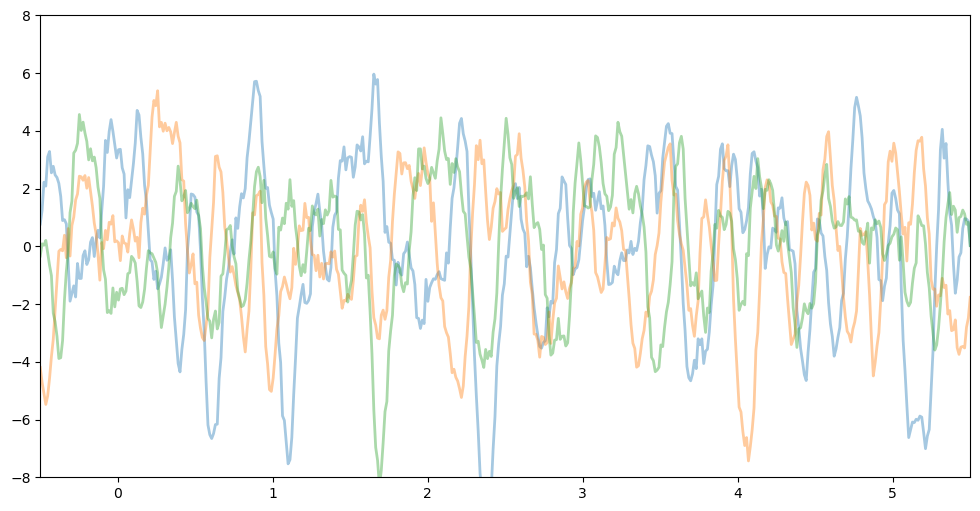

In [23]:
plot(model = gpr, kernel = kernel, n_prior_samples=3) # Samples from our prior
_ = plt.ylim((-8, 8))